In [ ]:
""" Form Google search urls for scraping """

GOOGLE_ORIG_URL = 'https://www.google.com/search?q=carbon+footprint'

page_amount = 11
GOOGLE_URLS = [GOOGLE_ORIG_URL + '&start=' + str(i*10) for i in range(0, page_amount)]
print(GOOGLE_URLS)

['https://www.google.com/search?q=carbon+footprint&start=0', 'https://www.google.com/search?q=carbon+footprint&start=10', 'https://www.google.com/search?q=carbon+footprint&start=20', 'https://www.google.com/search?q=carbon+footprint&start=30', 'https://www.google.com/search?q=carbon+footprint&start=40', 'https://www.google.com/search?q=carbon+footprint&start=50', 'https://www.google.com/search?q=carbon+footprint&start=60', 'https://www.google.com/search?q=carbon+footprint&start=70', 'https://www.google.com/search?q=carbon+footprint&start=80', 'https://www.google.com/search?q=carbon+footprint&start=90', 'https://www.google.com/search?q=carbon+footprint&start=100']


In [ ]:
# How to scrape HTML documents from Terminal
# wget --referer="http://www.google.com" --user-agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"   --header="Accept:text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5"   --header="Accept-Language: en-us,en;q=0.5"   --header="Accept-Encoding: gzip,deflate"   --header="Accept-Charset: ISO-8859-1,utf-8;q=0.7,*;q=0.7"   --header="Keep-Alive: 300" "$@" -q -O - https://www.google.com/search?q=carbon+footprint | gzip -dc > test.html


In [ ]:
""" Scrape Google search results """

import requests

s = requests.Session()
s.headers = {
    #"referer" : "http://www.google.com",
    "user-agent" : "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
}

def get_response(url):
    resp = s.get(url)
    if resp.status_code != 200:
        print(resp.text)
        raise
    return resp

google_responses = [get_response(url) for url in GOOGLE_URLS]
print(google_responses)

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]


In [ ]:
""" Parse scraped Google search results """

from bs4 import BeautifulSoup

def google_get_description(response):
    returnable=[]
    soup = BeautifulSoup(response.content, "html.parser")
    for s in soup.find_all("div", class_="g"):
        spans = s.find_all('span', class_=None)
        without_attrs = [s for s in spans if (s.attrs == {})]
        without_feedback = [s for s in without_attrs if 'Feedback' != s.text]
        without_cached = [s for s in without_feedback if 'Cached' != s.text]
        without_similar = [s for s in without_cached if 'Similar' != s.text]
        without_cachedsimilar = [s for s in without_similar if 'CachedSimilar' != s.text]
        for desc in without_cachedsimilar:
            desc_text = desc.text
            returnable.append(desc_text.replace('\xa0', ' '))
    return returnable

google_descriptions_of_pages = [google_get_description(res) for res in google_responses]

def flatten(t):
    return [item for sublist in t for item in sublist]

bs4_scraped_snippets = flatten(google_descriptions_of_pages)

print(*bs4_scraped_snippets[:15], sep='\n')
print(len(bs4_scraped_snippets))
# Possibly not usable data atm
# Although it doesn't cost anything to calc the metrics for this data also

A carbon footprint is the total amount of greenhouse gases (including carbon dioxide and methane) that are generated by our actions.
Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals.
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals.
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
A carbon footprint is the total amount of greenhouse gas emissions that come from the production, use and end-of-life of a product or service.
The calculator estimates your footprint in three areas: home energy, transportation and waste. Everyone's carbon footprint is differen

In [ ]:
""" Manually scraped snippets """

import csv

# Manually scraped data
# Done 06.10.2021, Oulu Finland
# URL = https://www.google.com/search?q=carbon+footprint
# Selecting next page by clicking
# Browser: Firefox (93.0, 64-bit)

with open('NLP_Carbon_Footprint_Google.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    manually_scraped_snippets = [row[2] for row in csv_reader] 
    print(*manually_scraped_snippets[:15], sep='\n')
    print(len(manually_scraped_snippets))
        

A carbon footprint is the total amount of greenhouse gases (including carbon dioxide and methane) that are generated by our actions. ... To have the best chance of avoiding a 2℃ rise in global temperatures, the average global carbon footprint per year needs to drop under 2 tons by 2050.
Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals. Free calculators · ‎Calculate · ‎About Us · ‎Business Carbon Footprint...
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
A carbon footprint is the total greenhouse gas (GHG) emissions caused by an individual, event, organization, service, place or product, expressed as carbon ... Background · ‎Measuring carbon footprints · ‎Causes · ‎Reducing carbon footprints
14.7.2016 — Many of our daily activities - such as using electricity, driving a car, or disposing of 

In [ ]:
""" BBC scrape """

import re

BBC_ORIG_URL = 'https://www.bbc.co.uk/search?q=carbon+footprint'

page_amount = 11
BBC_URLS = [BBC_ORIG_URL + '&page=' + str(i) for i in range(1, page_amount)]
#print(BBC_URLS)

bbc_responses = [get_response(url) for url in BBC_URLS]

def get_bbc_heading(response):
    returnable = []
    soup = BeautifulSoup(response.content, "html.parser")
    regex = re.compile('.*-Promo.')
    for a in soup.find_all("a", {"class" : regex}):
        returnable.append(a.text)
    return returnable

def get_bbc_description(response):
    returnable = []
    soup = BeautifulSoup(response.content, "html.parser")
    regex = re.compile('.*-Paragraph.')
    for p in soup.find_all("p", {"class" : regex}):
        if '© 2021 BBC. The BBC is not responsible for the content of external sites. Read about our approach to external linking.' in p.text:
            continue
        returnable.append(p.text)
    return returnable

bbc_headings_of_pages = [get_bbc_heading(res) for res in bbc_responses]
bbc_scraped_headings = flatten(bbc_headings_of_pages)
print(*bbc_scraped_headings[:15], sep='\n')
print(len(bbc_scraped_headings))

print('\n-----\n')

bbc_descriptions_of_pages = [get_bbc_description(res) for res in bbc_responses]
bbc_scraped_snippets = flatten(bbc_descriptions_of_pages)
print(*bbc_scraped_snippets[:15], sep='\n')
print(len(bbc_scraped_snippets))


Dani's House: Series 1: It's Not Easy Being Green
Clacton Airshow looks to reduce carbon footprint
Horizon: 2021: Feast to Save the Planet
Countryfile: Offa's Dyke Path
Royal Institution Christmas Lectures: 2020: Planet Earth - A User's Guide: Up in the Air
Hayley Goes...: Series 2: Back to Nature
Shop Well for the Planet?: Series 1: Episode 1
Newcastle's plastic grass sparks 'carbon footprint' row
Essex County Council leader makes LED street lights pledge
Firms want help to measure their carbon footprint
Do consumers care about carbon footprint?
University of Sheffield returns to churns for greener milk
Shop Well for the Planet?: Series 1: Episode 3
Farming Today: 19/08/21 - The carbon footprint of milk, Wheat harvest in Yorkshire
Coldplay go green for their next tour
100

-----

Sam dares Dani and Toby to cut their carbon footprint.
The Clacton Airshow is considering planting trees to offset emissions from next year's display.
A dinner party where special guests are scored on the env

In [ ]:
""" The Register scrape """

The_Register_ORIG_URL = 'https://search.theregister.com/?q=carbon+footprint&results_per_page=10&sort=rel'

page_amount = 11
The_Register_URLS = [The_Register_ORIG_URL + '&page=' + str(i) for i in range(1, page_amount)]

the_register_responses = [get_response(url) for url in The_Register_URLS]

def get_the_register_heading(response):
    returnable = []
    soup = BeautifulSoup(response.content, "html.parser")
    for article in soup.find_all("article"):
        for h4 in article.find_all("h4"):
            returnable.append(h4.text)
    return returnable

def get_the_register_description(response):
    returnable = []
    soup = BeautifulSoup(response.content, "html.parser")
    for article in soup.find_all("article"):
        for div in article.find_all("div", class_="standfirst"):
            returnable.append(div.text)
    return returnable

the_register_headings_of_pages = [get_the_register_heading(res) for res in the_register_responses]
the_register_scraped_headings = flatten(the_register_headings_of_pages)
print(*the_register_scraped_headings[:15], sep='\n')
print(len(the_register_scraped_headings))

print('\n-----\n')

the_register_descriptions_of_pages = [get_the_register_description(res) for res in the_register_responses]
the_register_scraped_snippets = flatten(the_register_descriptions_of_pages)
print(*the_register_scraped_snippets[:15], sep='\n')
print(len(the_register_scraped_snippets))


Amazon: Our carbon footprint went up 19% last year but we grew even more than that, so 'carbon intensity' is down
Measuring your carbon footprint? There's no app for that
AI me to the Moon... Carbon footprint for 'training GPT-3' same as driving to our natural satellite and back
Microsoft picks a side, aims to make the business 'carbon-negative' by 2030
Azure Emissions Dashboard shows how you and Microsoft are slowly killing the planet with your cloud workloads
Google Cloud will let you know how your workloads are damaging the environment
Japan's NTT Group to allow remote work for all 320,000 staff
Altered carbon: Boffins automate DNA storage with decent density – but lousy latency
Wipro wins $44.5m deal for data centres and managed services at UK's National Grid
'Green' Apple: We've smudged a bit off our carbon footprint
Brit MPs to Apple CEO: Please stop ignoring our questions about repairability and the environment
Bill Gates on climate change: Planting trees is not the answer, emis

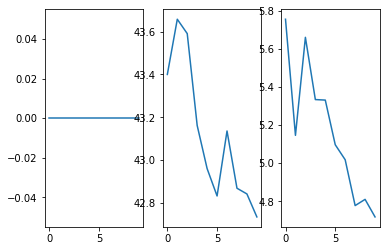

In [ ]:
""" FuzzyWuzzy """

from fuzzywuzzy import fuzz
import itertools
import numpy as np
import matplotlib.pyplot as plt

def wuzzy_string_matching(i, snippets):
    score_list = []
    V1 = 0
    if i * 10 >= len(snippets):
        combs = itertools.combinations(range(0,len(snippets)),2)
    else:
        combs = itertools.combinations(range(0,i*10),2)
    for id1, id2 in combs:
        ratio = fuzz.ratio(snippets[id1], snippets[id2])
        # V1 corresponding to the total number of similar snippets (string matching score equals 100%)
        if ratio == 100:
            V1 += 1
        score_list.append(ratio)

    # V2 for the average string matching of all pairs
    V2 = np.average(score_list)
    # V3 for the standard deviation corresponding to this average value.
    V3 = np.std(score_list)

    return V1,V2,V3

V1_list = []
V2_list = []
V3_list = []

for i in range(1, 11):
    V1, V2, V3 = wuzzy_string_matching(i, manually_scraped_snippets)
    V1_list.append(V1)
    V2_list.append(V2)
    V3_list.append(V3)

plt.subplot(131)
plt.plot(V1_list)
plt.subplot(132)
plt.plot(V2_list)
plt.subplot(133)
plt.plot(V3_list)
plt.show()

In [ ]:
!python -m spacy download en_core_web_sm 

2021-10-17 13:55:06.217643: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 13:55:06.217695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 7.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


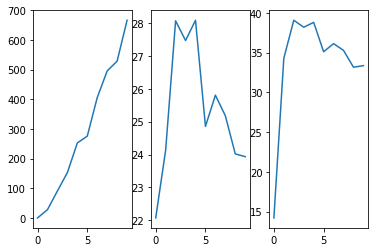

In [ ]:
"""Spacy named entities"""

import spacy

nlp = spacy.load("en_core_web_sm")

#initialize empty list for the entities
entities = []

#loop for going through all snippets
for i in range(0,100):
    doc = nlp(manually_scraped_snippets[i])
    #intialize temporarily variable
    lista = []
    #Calculate the entities
    for ent in doc.ents:   
        lista.append(ent)
    entities.append(lista)    

V1_4_list = []
V2_4_list = []
V3_4_list = []

for i in range(1, 11):
    V1, V2, V3 = wuzzy_string_matching(i, entities)
    V1_4_list.append(V1)
    V2_4_list.append(V2)
    V3_4_list.append(V3)

plt.subplot(131)
plt.plot(V1_4_list)
plt.subplot(132)
plt.plot(V2_4_list)
plt.subplot(133)
plt.plot(V3_4_list)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


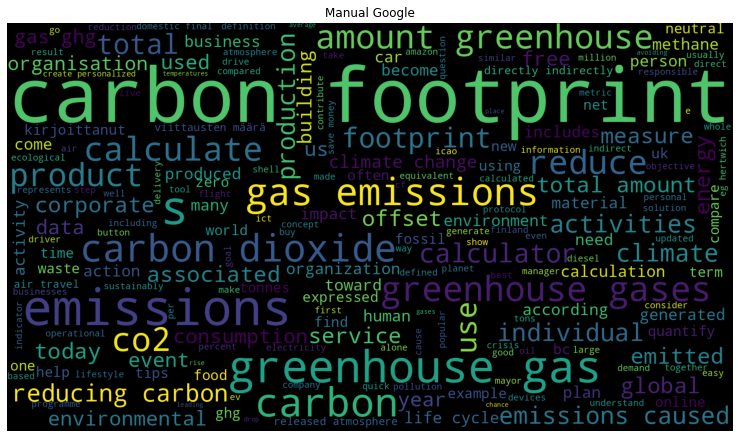

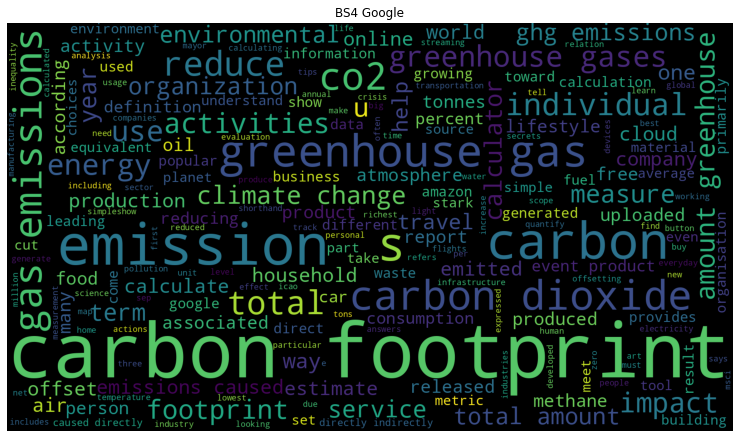

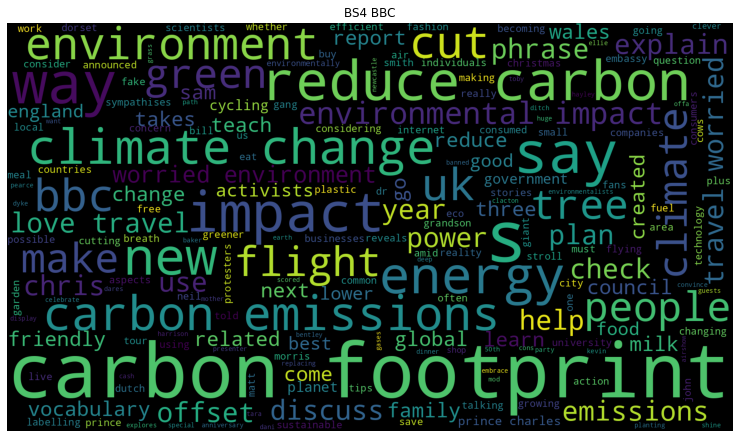

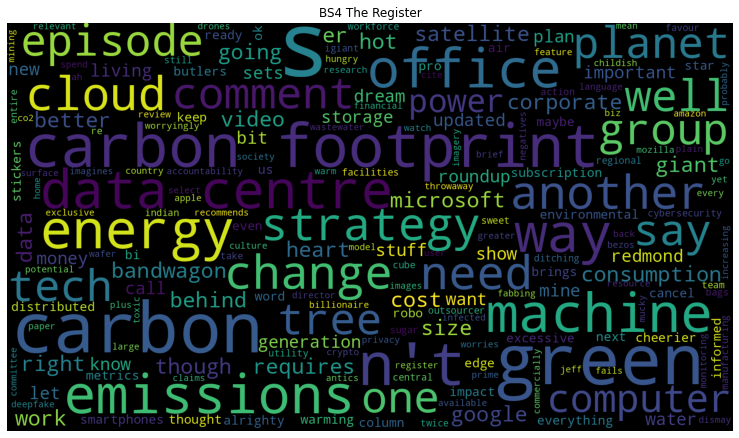

In [ ]:
""" WordCloud """

import matplotlib.pyplot as plot

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess(data):
    data = [item.lower() for item in data]
    stop_words = set(stopwords.words('english'))
    paragraph = ' '.join(data)
    word_tokens = word_tokenize(paragraph) 
    preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
    return preprocessed_data

def get_word_cloud(data, title):
    wordcloud = WordCloud(width=1600, height=900, max_font_size=200, background_color="black").generate(data)
    plot.figure(figsize=(13,11))
    plot.imshow(wordcloud)
    plot.axis("off")
    plot.title(title)
    return plot

manual_clean_data = preprocess(manually_scraped_snippets)
manual_plot = get_word_cloud(manual_clean_data, 'Manual Google')
manual_plot.show()

bs4_clean_data = preprocess(bs4_scraped_snippets)
bs4_plot = get_word_cloud(bs4_clean_data, 'BS4 Google')
bs4_plot.show()

bbc_clean_data = preprocess(bbc_scraped_snippets)
bbc_plot = get_word_cloud(bbc_clean_data, 'BS4 BBC')
bbc_plot.show()

the_register_clean_data = preprocess(the_register_scraped_snippets)
the_register_plot = get_word_cloud(the_register_clean_data, 'BS4 The Register')
the_register_plot.show()

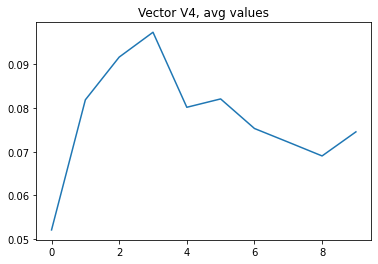

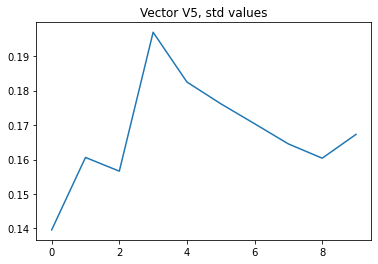

In [ ]:
""" Sentiment analysis """

from textblob import TextBlob
import matplotlib.pyplot as plt
#print(manually_scraped_snippets[15])

temp = TextBlob(manually_scraped_snippets[0])

polarity = []

for snippet in manually_scraped_snippets:
    text_blob = TextBlob(snippet)
    for sentence in text_blob.sentences:
        temp = (sentence.sentiment.polarity)
    polarity.append(temp)

#vector V4, average values and vector V5 std values
V4 = []
V5 = []
for i in range (10,110,10):
    V4.append(np.average(polarity[0:i]))
    V5.append(np.std(polarity[0:i]))

plt.figure(1)
plt.plot(V4)
plt.title("Vector V4, avg values")
plt.show()

plt.figure(2)
plt.plot(V5)
plt.title("Vector V5, std values")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df8df42c-8503-4bb3-8c9d-497cf36bf82c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>